In [14]:
from __future__ import print_function, unicode_literals, absolute_import, division
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm.auto import tqdm

from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import random_label_cmap, _draw_polygons
from stardist.models import StarDist2D

from skimage import measure
from skimage import draw
from skimage import morphology
from centroidtracker import CentroidTracker
from csbdeep.io import save_tiff_imagej_compatible
import matplotlib.pyplot as plt

import pims

import os
from pathlib import Path

In [19]:
# load in data
indir = '/Volumes/Coatamer/Users/weinberz/Desktop/20201028_locTest_TNF_thermo164588/20201024_locTest_TNF_4/Pos7'
tifs = []
for root, dirs, files in os.walk(indir):
    for file in files:
        if file.endswith('tif') & ('mask' not in file):
            tifs.append(Path(root) / file)

In [20]:
#construct ordered stacks
markers = pims.ImageSequence([tif for tif in tifs if 'CFP' in str(tif)])
query = pims.ImageSequence([tif for tif in tifs if 'RFP' in str(tif)])

In [34]:
#calculate background in query images by selecting 100 random points from each frame and averaging
bg_list = []
for frame in query:
    bg_points = list(np.random.choice(frame.flat, size=100, replace=False))
    bg_list = bg_list + bg_points
    
bg = np.mean(bg_list)

In [21]:
#load in model and predict for every frame in markers. save predictions into a list called "masks"

model = StarDist2D.from_pretrained('2D_versatile_fluo')
masks = []
for marker in markers:
    img = normalize(marker,1,99.8,axis=(0,1))
    labels, details = model.predict_instances(img, prob_thresh=0.8)
    masks.append(labels)

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


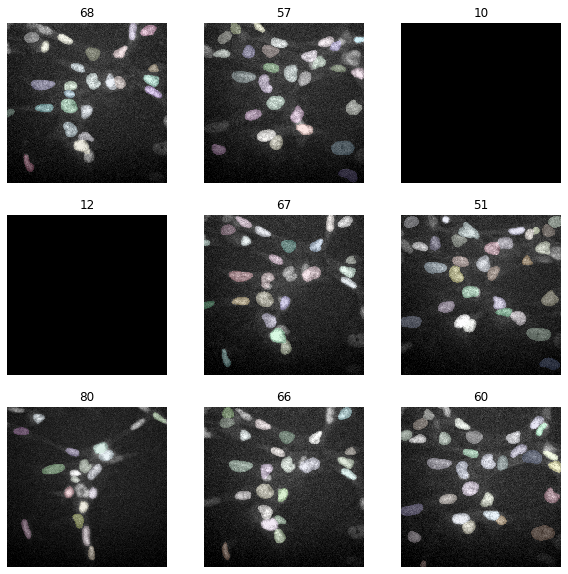

In [22]:
#check predictions across some random images
lbl_cmap = random_label_cmap()
fig, ax = plt.subplots(3,3, figsize=(10,10))
for a,x in zip(ax.flat, np.random.randint(0, high=len(markers), size=9)):
    img = normalize(markers[x],1,99.8,axis=(0,1))
    a.imshow(img, clim=(0,0.9), cmap='gray')
    a.imshow(masks[x], cmap=lbl_cmap, alpha=0.2)
    a.set_title(x)
    a.axis('off');

In [23]:
#track nuclei across frames
tracker = CentroidTracker(maxDisappeared=10)
data_list = []
cell_masks = []

for frame, mask in enumerate(masks):
    #make a blank mask that we will label with object ids
    cell_mask = np.zeros_like(mask)
    
    # get connected components in each frame
    label_props = measure.regionprops(mask)
    # find center position for each region
    centroids = [props.centroid for props in label_props]
    # convert to centroid: property pair for each label
    label_props = {centroid: props for centroid, props in zip(centroids, label_props)}
    # track the objects!
    objects = tracker.update(centroids)
    
    for obj, centroid in objects.items():
        # this try-except statement handles objects that
        # are missing in some frames
        try:
            cur_label = label_props[centroid].label
            label_mask = mask==cur_label
            nucleus = morphology.erosion(morphology.erosion(label_mask))
            cytosol = morphology.dilation(morphology.dilation(label_mask))^nucleus
            nuclear_signal = np.median(query[frame][nucleus])
            cytosol_signal = np.median(query[frame][cytosol])
            data = pd.Series({'frame': frame,
                              'cell' : obj,
                              'nucleus' : nuclear_signal,
                              'cytosol' : cytosol_signal,
                              'n/c': nuclear_signal/cytosol_signal})

            data_list.append(data)
            
            #add object to cell_mask
            cell_mask[mask==cur_label] = obj
        
        except KeyError:
            pass
        
    cell_masks.append(cell_mask)

In [ ]:
cell_list = []
for frame, mask in enumerate(masks):
    cur_label = 16.0
    label_mask = mask==cur_label
    nucleus = morphology.erosion(morphology.erosion(label_mask))
    cytosol = morphology.dilation(morphology.dilation(label_mask))^nucleus
    nuclear_signal = np.median(query[frame][nucleus])
    cytosol_signal = np.median(query[frame][cytosol])
    data = pd.Series({'frame': frame,
                      'cell' : obj,
                      'nucleus' : nuclear_signal,
                      'cytosol' : cytosol_signal,
                      'n/c': nuclear_signal/cytosol_signal})
    cell_list.append(data)
    
cell = pd.DataFrame(cell_list)

fig, axs = plt.subplot(1,3)
sns.lineplot(..., y='nucleus', ax=axs[0])
sns.lineplot(..., y='cytosol', ax=axs[1])
sns.lineplot(..., y='n/c', ax=axs[2])

In [ ]:
def norm_to_baseline(signal, baseline_n=10):
    baseline = np.mean(signal[0:baseline_n])
    return signal/baseline

data['normalized_n/c'] = (data.groupby('cell')['n/c']
                          .transform(norm_to_baseline)

In [44]:
# collect all data together and then filter by cytosol fluorescence and duration of detection
data = pd.DataFrame(data_list)
filtered_data = (data.groupby('cell')
                 .filter(lambda x: x['cytosol'].mean() > (1.1*bg)))
                 #.groupby('cell')
                 #.filter(lambda x: x['frame'].count() > (len(query)/2)))

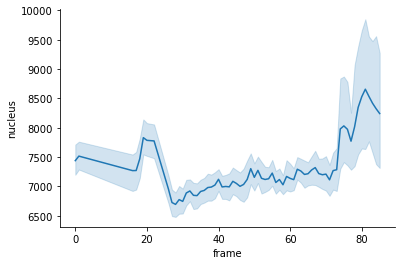

In [50]:
sns.lineplot(data=filtered_data, x='frame', y='nucleus')
sns.despine()

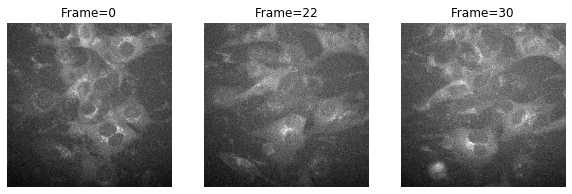

In [59]:
fig, ax = plt.subplots(1,3,figsize=(10,15))
ax[0].imshow(query[0], cmap='gray')
ax[0].set_title('Frame=0')
ax[1].imshow(query[22], cmap='gray')
ax[1].set_title('Frame=22')
ax[2].imshow(query[30], cmap='gray')
ax[2].set_title('Frame=30')
[a.axis('off') for a in ax]
plt.show()